<center> <b>Geospatial Fellows Program</b> </center>


# Identifying High Accuracy Regions in Traffic Camera Images to Enhance the Estimation of Road Traffic Metrics: A Quadtree-based Method and Applications 
<i>Ningchuan Xiao, Yue Lin</i>

This Jupyter notebook illustrates a quadtree-based algorithm to establish the image regions with high vehicle detection accuracy. A case study is presented to demonstrate how the use of these high accuracy regions can produce reliable road traffic metrics from traffic camera images.

## Notebook Outline
- [Introduction](#intro)
- [Vehicle detector](#det)
- [Quadtree-based algorithm for HAIR identification](#hair)
- [Georeferencing and traffic density estimation](#georef)
- [References](#ref)

<a id='intro'></a>
## Introduction
Traffic cameras have become an important data source for transportation management and control. However, deriving reliable traffic metrics from the camera feeds is challenging due to the limitations of current vehicle detection techniques, as well as the various camera conditions such as height and resolution. The figure below shows two examples of using a state-of-the-art deep learning detector to identify the vehicles in traffic images. It is clear that vehicles distant from the camera are often too small to be detected. Missed small vehicles tend to result in significant errors in the estimation of road traffic metrics. 

<img src='./figs/missed.png' width='800'/>

In this Jupyter notebook, we illustrate a quadtree-based algorithm that continuously partitions the image extent until only regions with high detection accuracy are remained. These regions are referred to as the high-accuracy identification regions (HAIR), which will be used to derive reliable road traffic metrics such as traffic density, flow, and speed. A case study in Central Ohio is presented to demonstrate how the use of HAIR can help to improve the accuracy of traffic density estimates using images from a camera. 

<a id='det'></a>
## Vehicle detector

The use of HAIR assumes that some object detector is available to identify the vehicles present in the images. In this project, a deep learning model called EfficientDet[<sup>1</sup>](#fn1) is used for vehicle identification. EfficientDet is a family of 8 object detection models (EfficientDet-d0 through d7) which share the same architecture. EfficientDet-d0 is the baseline model, and each of the next model has a larger size measured by its depth (number of layers), width (size of layers), and input image resolution. To train and evaluate the EfficientDet models, two data sets are prepared using the feeds from 249 cameras in Central Ohio, which consists of 1,392 and 465 images, respectively. Both data sets are processed through an annotation process where bounding boxes of the vehicles are manually identified. Since the deep learning literature generally suggests the use of a large and diverse training data set to improve detection accuracy, we enrich our training data by two external data sources, STREETS[<sup>2</sup>](#fn2) and WebCamT[<sup>3</sup>](#fn3). The figure below presents the training and evaluation of EfficientDet for vehicle detection.

<img src='./figs/vehicle_detection.png' width='500'/>

<a id='hair'></a>
## Quadtree-based algorithm for HAIR identification
The purpose of our quadtree-based HAIR identification algorithm is to determine the regions in a camera’s field of view that are part of the high accuracy regions. A number of images ($N$) are needed as the input of this algorithm, where each image contains (1) the manually labeled vehicle bounding boxes that are confirmed to be the ground truth of the vehicles to be detected, and (2) the bounding box of each detected vehicle yielded by some model. Here, we prepare a sample image data set collected from a traffic camera located in Central Ohio. This data set uses similar format to PASCAL VOC 2007[<sup>4</sup>](#fn4), with its directory structured as:  

     |-- sample_cam
        |-- Annotations
        |-- ImageSets
            |-- Main
        |-- JPEGImages
        |-- Predictions

The labeled vehicle bounding boxes are stored under the *Annotations* directory in .xml format, each linked to a traffic image in the *JPEGImages* directory and a filename in the *ImageSets -> Main* directory. The *Predictions* directory contains the predicted vehicle bounding boxes generated by the trained EfficientDet model.

In [68]:
from zipfile import ZipFile
with ZipFile('data/sample_cam.zip', 'r') as zipObj:
  zipObj.extractall('data')

Visualize an image after detection.

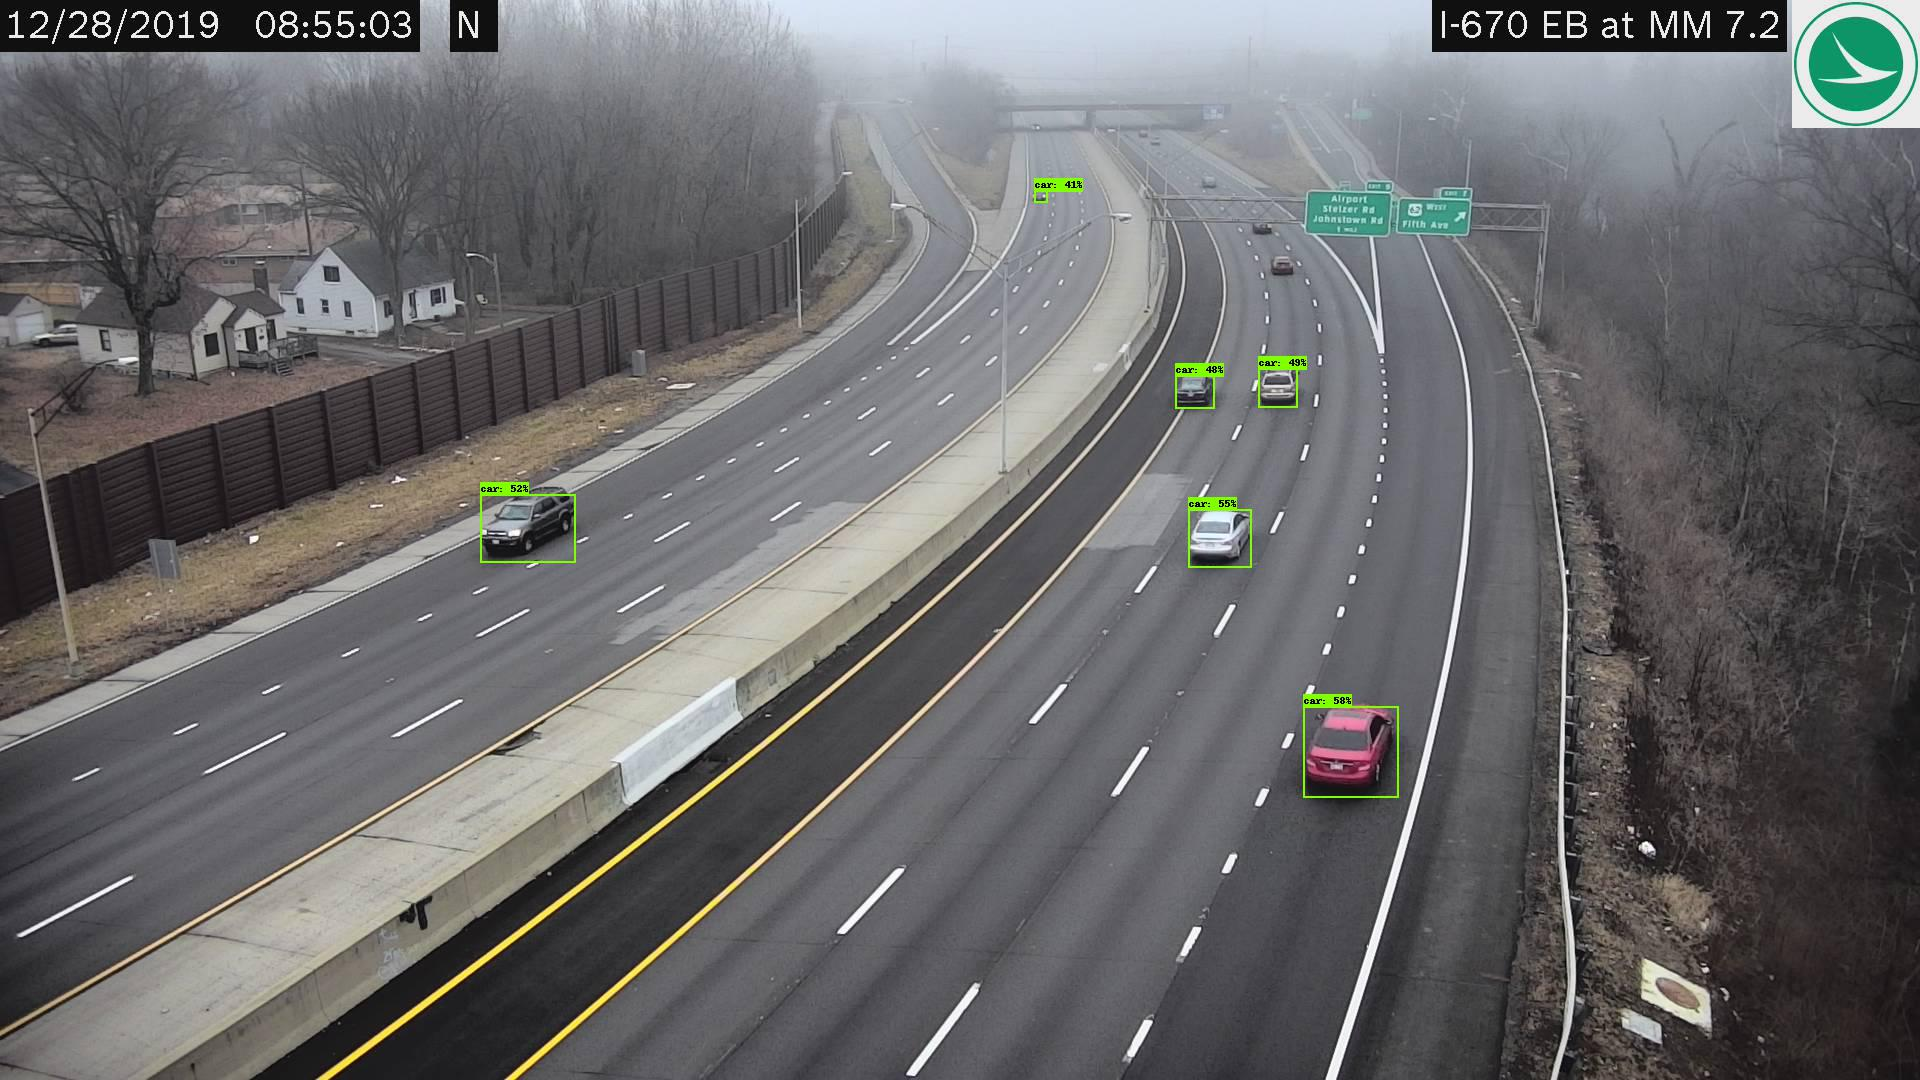

In [75]:
from IPython.display import Image 
pil_img = Image(filename = 'data/sample_cam/Predictions/2019-12-28_08_55_01_camera_145.jpg', width = 600)
display(pil_img)

The `sampling` function allows users to specify different numbers of images ($N$) when implementing the algorithm.

In [44]:
def sampling(imagesetfile, samplesize):
  with open(imagesetfile, 'r') as f:
    lines = f.readlines()
  imagenames = [x.strip() for x in lines]
  shuffle(imagenames)
  imagenames = sample(imagenames, samplesize)
  return imagenames

Then, we define the `QuadTreeNode` class. A quadtree node refers to a quadrant/sub-quadrant in the image extent. `QuadTreeNode`
strores the extent of the quadrant/sub-quadrant, its four children (possibly all `NULL` if not partitioned), its accuracy measures (regional average precision, precision, recall, F1-score, and accuracy), and whether or not it is selected as part of the HAIR.

In [43]:
class QuadTreeNode(object):
  def __init__(self, extent, nw=None, ne=None, se=None, sw=None, 
                rap=0, prec=0, rec=0, f1=0, acc=0, selected=False):
    self.extent = extent
    self.nw = nw
    self.ne = ne
    self.se = se
    self.sw = sw
    
    self.rap = rap
    self.prec = prec
    self.rec = rec
    self.f1 = f1
    self.acc = acc
    self.selected = selected

The regional average precision of a quadtree node is similar to the average precision metric[<sup>4</sup>](#fn4). It is computed based on the bounding boxes of all the labeled and detected vehicles in the region. If the regional average precision of a node does not reach a user-specified threshold ($a_0$), the `build_qtree` function will partition the corresponding quadrant into four equal sub-quadrants. This process continues until either the accuracy threshold ($a_0$) or the maximal depth ($d_0$) is reached.

In [51]:
def build_qtree(t, imagenames, thresh, maxdepth):
    if not t: 
      return
    
    roibbox = t.extent
    xmin = roibbox[0]
    ymin = roibbox[1]
    xmax = roibbox[2]
    ymax = roibbox[3]
    xmid = (xmin + xmax) / 2.
    ymid = (ymin + ymax) / 2.
    if xmax - xmin < W * 1/2**maxdepth:
      return

    rec, prec, rap, acc = eval.voc_eval(DETPATH, ANNOPATH, imagenames, CLASSNAME, CACHEDIR,
                             roibbox, ovthresh = 0.5, use_07_metric = True)
    if len(rec) != 0 and len(prec) != 0:   
      f1 = 2 * rec[-1] * prec[-1] / (rec[-1] + prec[-1])
      t.rec = rec[-1]
      t.prec = prec[-1]
      t.f1 = f1

    t.rap = rap
    t.acc = acc

    if t.rap >= thresh:
      t.selected = True
    else:
      t.nw = QuadTreeNode([xmin, ymin, xmid, ymid])
      t.ne = QuadTreeNode([xmid, ymin, xmax, ymid])
      t.se = QuadTreeNode([xmid, ymid, xmax, ymax])
      t.sw = QuadTreeNode([xmin, ymid, xmid, ymax])

      build_qtree(t.nw, imagenames, thresh, maxdepth)
      build_qtree(t.ne, imagenames, thresh, maxdepth)
      build_qtree(t.se, imagenames, thresh, maxdepth)
      build_qtree(t.sw, imagenames, thresh, maxdepth)

The `search_qtree` function outputs the derived HAIR.

In [52]:
def search_qtree(t, p):
    if t is None:
      return
    
    px = p[0]
    py = p[1]

    xmin = t.extent[0]
    ymin = t.extent[1]
    xmax = t.extent[2]
    ymax = t.extent[3]
    xmid = (xmin + xmax) / 2.
    ymid = (ymin + ymax) / 2.

    if xmin <= px < xmax and ymin <= py < ymax:
      if t.selected == True:
        return True
      elif t.nw or t.ne or t.se or t.sw:
        if xmin <= px < xmid and ymin <= py < ymid:
          return search_qtree(t.nw, p)
        elif xmid <= px < xmax and ymin <= py < ymid:
          return search_qtree(t.ne, p)
        elif xmid <= px < xmax and ymid <= py < ymax:
          return search_qtree(t.se, p)
        elif xmin <= px < xmid and ymid <= py < ymax:
          return search_qtree(t.sw, p)

Now we have defined all the necessary class and functions. One step before running the algorithm, we need to setup some libraries and input parameters.

In [64]:
from random import sample, shuffle, seed
import numpy as np
from model import eval
import warnings
warnings.filterwarnings('ignore')

DETPATH = "data/sample_cam/Predictions"
ANNOPATH = "data/sample_cam/Annotations"
IMAGESETFILE = "data/sample_cam/ImageSets/Main/trainval.txt"
CLASSNAME = "car"
CACHEDIR = "data/sample_cam/cache"
H = 1080
W = 1920
imageextent = [0, 0, W, H]
samplesize = 50           # number of images
thresh = 0.75             # accuracy threshold
maxdepth = 3              # maximal depth

Extract and print out the HAIR in a matrix form. Try different seeds if you want.

In [65]:
seed(1)
# initialize quads
quads = np.zeros((2**maxdepth, 2**maxdepth))

# obtain the HAIR
imagenames = sampling(IMAGESETFILE, samplesize)
t = QuadTreeNode(imageextent)
build_qtree(t, imagenames, thresh, maxdepth)

# print out the HAIR
for i in range(2**maxdepth):
  ymin = imageextent[1] + i * H * 1/2**maxdepth
  for j in range(2**maxdepth):
    xmin = imageextent[0] + j * W * 1/2**maxdepth
    p = [xmin, ymin]
    if search_qtree(t, p):
      quads[i,j] = 1.

print(quads)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


In [62]:
n = 10                  # Bootstrap times

# initialize quads
quads = np.zeros((2**maxdepth, 2**maxdepth))

# bootstrap
for k in range(n):
  imagenames = sampling(IMAGESETFILE, samplesize)
  t = QuadTreeNode(imageextent)
  build_qtree(t, imagenames, thresh, maxdepth)

  for i in range(2**maxdepth):
    ymin = imageextent[1] + i * H * 1/2**maxdepth
    for j in range(2**maxdepth):
      xmin = imageextent[0] + j * W * 1/2**maxdepth
      p = [xmin, ymin]
      if search_qtree(t, p):
        quads[i,j] += 1./n

print(quads)

[[0.5 0.5 0.5 0.5 0.  0.  0.  0. ]
 [0.5 0.5 0.5 0.5 0.  0.  0.  0. ]
 [0.5 0.5 1.  1.  0.9 0.9 0.  0. ]
 [0.5 0.5 1.  1.  1.  1.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]]


<a id='georef'></a>
## Georeferencing and traffic density estimation

To estimate the road traffic metrics (e.g., traffic density) using the HAIR, the images involved are assumed to be georeferenced. To georeference the test images, an orthorectified images covering the study area is retrieved from the [Ohio Statewide Imagery Program](http://gis5.oit.ohio.gov/geodatadownload/). We identify 10 ground control points within the camera's field of view (see the figure below). The Georeferencer plugin in [QGIS](https://www.qgis.org/en/site/) is utilized to georeference the camera images to the coordinate system in the orthorectified aerial photos. Traffic density is estimated based on the traffic counts and road lengths within the HAIR. 

<img src='./figs/georef.png' width='400'/>

<a id='ref'></a>
## References
<span id="fn1"> Tan, M., Pang, R., Le, Q. V., 2020a. EfficientDet: Scalable and Efficient Object Detection, in: Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR). pp. 10781–10790. </span>

<span id="fn2"> Snyder, C., Do, M.N., 2019. STREETS: A Novel Camera Network Dataset for Traffic Flow, in: Wallach, H., Larochelle, H., Beygelzimer, A., D’Alché-Buc, F., Fox, E., Garnett, R. (Eds.), Advances in Neural Information Processing Systems 32 (NIPS 2019). Curran Associates, Inc., New York, US, pp. 10242–10253. </span>

<span id="fn3"> Zhang, S., Wu, G., Costeira, J.P., Moura, J.M.F., 2017. Understanding Traffic Density from Large-Scale Web Camera Data, in: Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Honolulu, HI, USA, pp. 4264–4273. </span>

<span id="fn4"> Everingham, M., Gool, L.J. Van, Williams, C., Winn, J.M., Zisserman, A., 2010. The Pascal Visual Object Classes (VOC) Challenge. Int. J. Comput. Vis. 88, 303–338. </span> 